In [31]:
# github link
# https://github.com/UNU-0401/deep-learning_class/blob/main/README.md

In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
mnist_train= dset.MNIST("", train= True, transform= transforms.ToTensor(),
                       target_transform= None, download= True)
mnist_test= dset.MNIST("", train= False, transform= transforms.ToTensor(),
                       target_transform= None, download= True)

mnist_train 길이:  60000
mnist_test 길이:  10000
image data 형태:  torch.Size([1, 28, 28])
label:  5


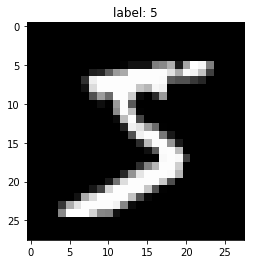

In [6]:
print "mnist_train 길이: ", len(mnist_train)
print "mnist_test 길이: ", len(mnist_test)

#데이터 하나 형태
image, label= mnist_train.__getitem__(0) #0th data
print "image data 형태: ", image.size()
print "label: ", label

#그리기
img= image.numpy() #image type -> numpy type(1, 28, 28)
plt.title("label: %d"%label)
plt.imshow(img[0], cmap= 'gray')
plt.show()

5
torch.Size([1, 28, 28])
5


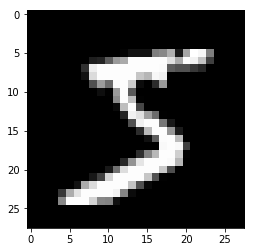

0


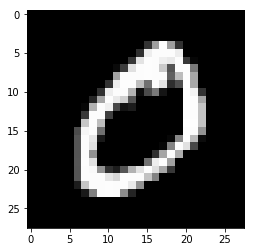

4


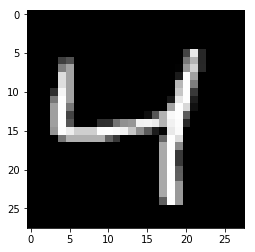

In [7]:
print(mnist_train[0][1]) #0th data' label
print(mnist_train[0][0].size()) #0th data' image size

for i in range(3):
    img= mnist_train[i][0].numpy() # i번째 data' image를 numpy 형태로
    print(mnist_train[i][1]) #i번째 data' label 출력
    plt.imshow(img[0], cmap= 'gray') #i번째 data' image
    plt.show()

torch.Size([1, 1, 28, 28])
5
torch.Size([1, 3, 28, 28])


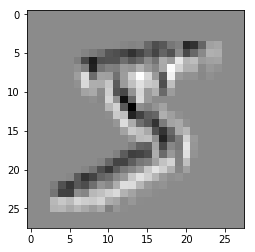

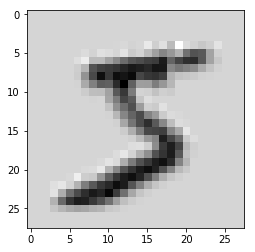

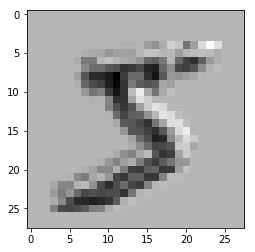

In [8]:
#mnist의 첫 번째 이미지, 라벨 가져오기
image, label= mnist_train[0]

#[1, 28, 28]-> [1, 1, 28, 28] : 
#추가된 1: batch_size(이번엔 데이터 1개만 넣어볼 거라 batch_size=1)
image= image.view(-1, image.size()[0], image.size()[1], image.size()[2])
print(image.size())

print label

#convolutional filter 정의
conv_layer= nn.Conv2d(in_channels=1, out_channels=3, kernel_size= 3, padding=1)
#image에 filter 적용(아무것도 지정 안 했으므로 default filter 적용됨)
output= conv_layer(Variable(image))
print(output.size())

for i in range(3): #channel에 따라 그리겠다
    # 해당 channel에 속하는 모든 원소(h, w)를 그리겠다
    plt.imshow(output[0, i, :, :].data.numpy(), cmap= 'gray')
    plt.show()

In [9]:
import numpy as np
import torch.optim as optim

batch_size= 16
learning_rate= 0.0002
num_epoch= 10

In [11]:
train_loader= torch.utils.data.DataLoader(list(mnist_train)[:batch_size*100], 
                                         batch_size=batch_size, shuffle=True,
                                         num_workers=2, drop_last=True)
test_loader= torch.utils.data.DataLoader(mnist_test, 
                                         batch_size=batch_size, shuffle=False,
                                         num_workers=2, drop_last=True)

In [16]:
# cnn class 만들기(모델 만들기)
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer= nn.Sequential(
            
            # (I - F + 2P)/S +1 -> (28- 5 + 2*2)/1 +1 = 28(next layer' img size)
            #input # of channel =1, # of feature map(: # of channel)= 16, 
            #kernel size= 5
            #학습시켜야할 # of parameter: (5*5*1)*16 +16(bias)
            nn.Conv2d(1, 16, 5, padding= 2),
            nn.ReLU(),
            
            # (I - F + 2P)/S +1 -> (28- 5 + 2*2)/1 +1 = 28(next layer' img size)
            #input # of channel =16, feature map size(: # of channel)= 32
            #학습시켜야할 # of parameter: (5*5*16)*32 +32(bias)
            nn.Conv2d(16, 32, 5, padding= 2),
            nn.ReLU(),
            nn.MaxPool2d(2,2), # 28*28 -> 14*14(h*w) (-> channel 수는 그대로)
            
            # (I - F + 2P)/S +1 -> (14- 5 + 2*2)/1 +1 = 14(next layer' img size)
            #input # of channel =32, feature map size(: # of channel)= 64
            #학습시켜야할 # of parameter: (5*5*32)*64 +64(bias)
            nn.Conv2d(32, 64, 5, padding= 2),
            nn.ReLU(),
            nn.MaxPool2d(2,2) #14*14 -> 7*7(h*w) (-> channel 수는 그대로)
            )
        
        self.fc_layer= nn.Sequential( #fully-connected-layer
            nn.Linear(64*7*7, 100),
            nn.ReLU(),
            nn.Linear(100, 10)
        )
        
    def forward(self, x):
        out= self.layer(x)
        out= out.view(batch_size, -1)
        out= self.fc_layer(out)
        return out
        

model= CNN()        

In [17]:
#파라미터 체크하기
for parameter in model.parameters():
    #print(parameter) -> kernel의 실제 원소값이 출력됨
    print(parameter.shape)

torch.Size([16, 1, 5, 5])
torch.Size([16])
torch.Size([32, 16, 5, 5])
torch.Size([32])
torch.Size([64, 32, 5, 5])
torch.Size([64])
torch.Size([100, 3136])
torch.Size([100])
torch.Size([10, 100])
torch.Size([10])


In [18]:
#loss function, optimizer 선언
loss_func= nn.CrossEntropyLoss()
optimizer= torch.optim.Adam(model.parameters(), lr= learning_rate)

In [20]:
#optimization

for i in range(num_epoch):
    for j, [image, label] in enumerate(train_loader): #batch_size만큼
        x= Variable(image)
        y_= Variable(label)
        
        optimizer.zero_grad() #optimizer 안에서 이전 gradient들을 초기화
        output= model.forward(x)
        loss= loss_func(output, y_)
        loss.backward() #gradient 계산
        optimizer.step #parameter update
        
        if j%50==0:
            print(loss, j, i)

(tensor(2.3095, grad_fn=<NllLossBackward>), 0, 0)
(tensor(2.3104, grad_fn=<NllLossBackward>), 50, 0)
(tensor(2.2976, grad_fn=<NllLossBackward>), 0, 1)
(tensor(2.2905, grad_fn=<NllLossBackward>), 50, 1)
(tensor(2.2902, grad_fn=<NllLossBackward>), 0, 2)
(tensor(2.2900, grad_fn=<NllLossBackward>), 50, 2)
(tensor(2.2867, grad_fn=<NllLossBackward>), 0, 3)
(tensor(2.3053, grad_fn=<NllLossBackward>), 50, 3)
(tensor(2.2637, grad_fn=<NllLossBackward>), 0, 4)
(tensor(2.2877, grad_fn=<NllLossBackward>), 50, 4)
(tensor(2.3062, grad_fn=<NllLossBackward>), 0, 5)
(tensor(2.2780, grad_fn=<NllLossBackward>), 50, 5)
(tensor(2.2994, grad_fn=<NllLossBackward>), 0, 6)
(tensor(2.3004, grad_fn=<NllLossBackward>), 50, 6)
(tensor(2.2966, grad_fn=<NllLossBackward>), 0, 7)
(tensor(2.3168, grad_fn=<NllLossBackward>), 50, 7)
(tensor(2.3059, grad_fn=<NllLossBackward>), 0, 8)
(tensor(2.2824, grad_fn=<NllLossBackward>), 50, 8)
(tensor(2.2980, grad_fn=<NllLossBackward>), 0, 9)
(tensor(2.2995, grad_fn=<NllLossBackward>

In [21]:
#모델 저장시키기
torch.save(model, 'nets/mycnn_model_%d.pkl'%(num_epoch))

/home/ec2-user/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [22]:
try:
    #미리 학습시킨 네트워크의 파라미터 집합
    model= torch.load('nets/mycnn_model_10.pkl')
    print("model restored")
except:
    print("model not resotred")

model restored


In [29]:
def ComputeAccr(dloader, imodel):
    correct= 0
    total= 0
    
    for j, [imgs, labels] in enumerate(dloader): #batch_size 만큼
        img= Variable(imgs) #x
        label= Variable(labels) #y
        
        output= imodel.forward(img)
        _, output_index= torch.max(output, 1)
        
        total += label.size(0)
        correct += (output_index == label).sum().float()
    print("Accuracy of Test Data: {}".format(100*correct/total))
        

In [30]:
ComputeAccr(test_loader, model)

Accuracy of Test Data: 8.92000007629
